## import python libraries

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.optimize import linear_sum_assignment

color_set = sns.color_palette('Set2', as_cmap=True)

## define helper functions

In [2]:
def load_data(sigra_root, scanpy_root, spagcn_root, stlearn_root, seurat_root=None, bayesspace_root=None, num_cluster=8):
    sigra = sc.read(sigra_root)
    sigra = leiden_cluster(sigra, num_cluster, seed=1234)
    sigra.obs['sigra'] = sigra.obs['leiden']
    
    scanpy = sc.read(scanpy_root)
    scanpy.obs['leiden'] = scanpy.obs['leiden'].astype('category')
    
    spagcn = sc.read(spagcn_root)
    spagcn.obs['refined_pred'] = spagcn.obs['refined_pred'].astype('category')
#     spagcn.obs['pred'] = spagcn.obs['pred'].astype('category')


    
    stlearn = pd.read_csv(stlearn_root, header=0, index_col=0)
    
    seurat = pd.read_csv(seurat_root, header=0, index_col=0)
    bayesspace = pd.read_csv(bayesspace_root, header=0, index_col=0, sep=',')
    
    sigra.obs['scanpy'] = scanpy.obs['leiden'].astype('category')
    sigra.obs['spagcn'] = spagcn.obs['refined_pred'].astype('category')
    sigra.obs['stlearn'] = stlearn['X_pca_kmeans'].astype('category')
    sigra.obs['seurat'] = seurat['seurat_clusters'].astype('category')
    sigra.obs['bayesspace'] = bayesspace['spatial.cluster'].astype('category')
    return sigra

def _hungarian_match(flat_preds, flat_target, preds_k, target_k):
    num_samples = flat_preds.shape[0]
    num_k = preds_k
    num_correct = np.zeros((num_k, num_k))
    for c1 in range(num_k):
        for c2 in range(num_k):
            votes = int(((flat_preds==c1)*(flat_target==c2)).sum())
            num_correct[c1, c2] = votes
    
    match = linear_sum_assignment(num_samples-num_correct)
    match = np.array(list(zip(*match)))
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))
    return res

def match_anno(annotation, data, name='leiden'):
    gt = annotation.cat.codes
    gt_dict = {}
    for k, n in zip(gt, annotation):
        gt_dict[k] = n
    
    pred = data.obs[name].astype('category').cat.codes
    pred_dict = {}
    for k, n in zip(pred, data.obs[name]):
        pred_dict[k] = n
    
    match = _hungarian_match(pred.astype(np.int), gt.astype(np.int), len(set(pred)), len(set(gt)))
    print(match)
    
    match_dict = {}
    for a,b in match:
        match_dict[a] = b
    
    matched_gt = []
    for k in pred:
        matched_gt.append(gt_dict[match_dict[k]])
    if name == 'leiden':
        data.obs['sigra_matched'] = matched_gt
    else:
        data.obs[name+'_matched'] = matched_gt
    return data

def res_search(adata_pred, ncluster, seed, iter=200):
        start = 0; end =3
        i = 0
        while(start < end):
            if i >= iter: return res
            i += 1
            res = (start + end) / 2
            random.seed(seed)
            os.environ['PYTHONHASHSEED'] = str(seed)
            np.random.seed(seed)

            os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

            sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
            count = len(set(adata_pred.obs['leiden']))
            print('res: %.2f, count: %d, ncluster: %d'%(res, count, ncluster))
            if int(count) == ncluster:
                print('find', res)
                return res
            if count > ncluster:
                end = res
            else:
                start = res
        raise NotImplementedError()

def leiden_cluster(adata, ncluster=8, seed=1234, name='leiden'):
#     print(ncluster)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    sc.pp.neighbors(adata, 20, use_rep='pred', random_state=seed)
    res = res_search(adata, ncluster, seed)
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    sc.tl.leiden(adata, resolution=res, key_added=name, random_state=seed)
    return adata


## Comparision with the benchmarking papers
1. load data and annotation
2. run clustering results from leiden
3. match clustering from comparisions
4. match the clusters from comparisions

In [3]:
root = 'adatas'
slice_id = '10x_Prostate_Cancer_'
num_cluster = 3
raw_adata = sc.read(os.path.join(root, f'{slice_id}raw.h5ad'))

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
sigra_root = os.path.join(root, f'{slice_id}sigra_final.h5ad')
scanpy_root = os.path.join(root, f'{slice_id}scanpy.h5ad')
spagcn_root = os.path.join(root, f'{slice_id}spaGCN.h5ad')
stlearn_root = os.path.join(root, f'{slice_id}stlearn.csv')
seurat_root = os.path.join(root, f'{slice_id}Seurat.csv')
bspace_root = os.path.join(root, f'{slice_id}bayesSpace.csv')
sigra = load_data(sigra_root, scanpy_root, spagcn_root, stlearn_root, seurat_root, bspace_root, num_cluster=num_cluster)


res: 1.50, count: 22, ncluster: 3
res: 0.75, count: 15, ncluster: 3
res: 0.38, count: 7, ncluster: 3
res: 0.19, count: 5, ncluster: 3
res: 0.09, count: 3, ncluster: 3
find 0.09375


In [5]:
sigra.obs['annotation'] = raw_adata.obs['annotation']

In [6]:
sigra = match_anno(sigra.obs['annotation'], sigra, name='sigra')
sigra = match_anno(sigra.obs['annotation'], sigra, name='scanpy')
sigra = match_anno(sigra.obs['annotation'], sigra, name='spagcn')
sigra = match_anno(sigra.obs['annotation'], sigra, name='stlearn')
sigra = match_anno(sigra.obs['annotation'], sigra, name='seurat')
sigra = match_anno(sigra.obs['annotation'], sigra, name='bayesspace')

[(0, 2), (1, 1), (2, 0)]
[(0, 1), (1, 0), (2, 2)]
[(0, 1), (1, 2), (2, 0)]
[(0, 2), (1, 1), (2, 0)]
[(0, 2), (1, 1), (2, 0)]
[(0, 0), (1, 1), (2, 2)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## draw spatial images and compare with benchmarks
1. define helper functions
2. draw spatial images
3. save in './pdfs/'

In [7]:
def draw_with_ax(adata, ax, name, title):
    obs_df = adata.obs.dropna()
    ARI = adjusted_rand_score(obs_df[name], obs_df['annotation'])
    sc.pl.spatial(adata, color=[name], title=title, show=False, ax=ax)
    ax.axis('off')
    ax.set_title('%s, ARI: %.2f'%(title, ARI))
    
def draw_spatial_benchmarks(adata, save_path='pdfs/a.pdf'):
    fig, axs = plt.subplots(3,3, figsize=(12,8))
    axs[0,0].axis('off')
    axs[0,1].axis('off')
    axs[0,2].axis('off')

    sc.pl.spatial(adata, color=['annotation'], title=['annotation'], show=False, ax=axs[0,1])
    axs[0,1].set_title('Annotation')

    draw_with_ax(adata, axs[1,0], 'sigra_matched', 'sigra')
    draw_with_ax(adata, axs[1,1], 'scanpy_matched', 'scanpy')
    draw_with_ax(adata, axs[1,2], 'spagcn_matched', 'spaGCN')
    draw_with_ax(adata, axs[2,0], 'stlearn_matched', 'stlearn')
    draw_with_ax(adata, axs[2,1], 'seurat_matched', 'seurat')
    draw_with_ax(adata, axs[2,2], 'bayesspace_matched', 'bayesspace')

    plt.tight_layout()
    
    plt.savefig(save_path)

In [8]:
if not os.path.exists('pdfs'):
    os.makedirs('pdfs')

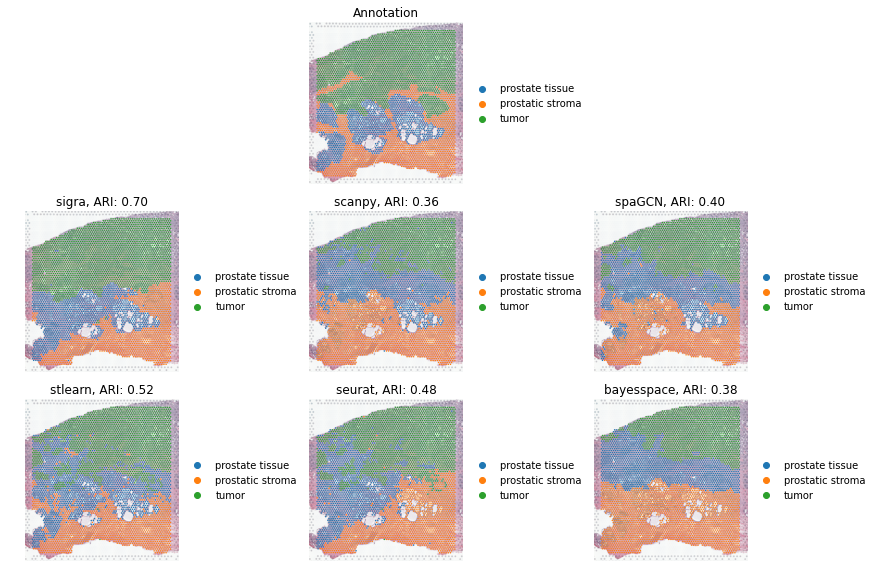

In [9]:
draw_spatial_benchmarks(sigra, save_path=f'pdfs/{slice_id}_benchmark.pdf')

## draw spatial with ablation studies
1. load data from ablation studies
2. draw the spatial images
3. save in './pdfs/'

In [10]:
def get_leiden_from_ablation(root, num_cluster):
    adata = sc.read(root)
    adata = leiden_cluster(adata, num_cluster, seed=1234)
    return adata.obs['leiden']

In [11]:
gene_only = get_leiden_from_ablation(f'{root}/{slice_id}gene.h5ad', num_cluster)
img_gene = get_leiden_from_ablation(f'{root}/{slice_id}img_gene.h5ad', num_cluster)
img_img = get_leiden_from_ablation(f'{root}/{slice_id}img_img.h5ad',num_cluster)
combine_only = get_leiden_from_ablation(f'{root}/{slice_id}combine_only.h5ad', num_cluster)


res: 1.50, count: 24, ncluster: 3
res: 0.75, count: 14, ncluster: 3
res: 0.38, count: 9, ncluster: 3
res: 0.19, count: 7, ncluster: 3
res: 0.09, count: 4, ncluster: 3
res: 0.05, count: 2, ncluster: 3
res: 0.07, count: 4, ncluster: 3
res: 0.06, count: 3, ncluster: 3
find 0.05859375
res: 1.50, count: 17, ncluster: 3
res: 0.75, count: 9, ncluster: 3
res: 0.38, count: 4, ncluster: 3
res: 0.19, count: 3, ncluster: 3
find 0.1875
res: 1.50, count: 28, ncluster: 3
res: 0.75, count: 17, ncluster: 3
res: 0.38, count: 11, ncluster: 3
res: 0.19, count: 7, ncluster: 3
res: 0.09, count: 4, ncluster: 3
res: 0.05, count: 3, ncluster: 3
find 0.046875
res: 1.50, count: 23, ncluster: 3
res: 0.75, count: 15, ncluster: 3
res: 0.38, count: 9, ncluster: 3
res: 0.19, count: 7, ncluster: 3
res: 0.09, count: 4, ncluster: 3
res: 0.05, count: 2, ncluster: 3
res: 0.07, count: 3, ncluster: 3
find 0.0703125


In [12]:
sigra.obs['gene_only'] = gene_only
sigra.obs['img_gene'] = img_gene
sigra.obs['img_img'] = img_img
sigra.obs['combine_only'] = combine_only
sigra = match_anno(sigra.obs['annotation'], sigra, name='gene_only')
sigra = match_anno(sigra.obs['annotation'], sigra, name='img_gene')
sigra = match_anno(sigra.obs['annotation'], sigra, name='img_img')
sigra = match_anno(sigra.obs['annotation'], sigra, name='combine_only')

[(0, 1), (1, 0), (2, 2)]
[(0, 2), (1, 0), (2, 1)]
[(0, 2), (1, 1), (2, 0)]
[(0, 1), (1, 2), (2, 0)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [13]:
def draw_spatial_ablation(adata, save_path='pdfs/b.pdf'):
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    axs[0,0].axis('off')
    sc.pl.spatial(adata, color=['annotation'], title=['annotation'], show=False, ax=axs[0,0])
    axs[0,0].set_title('Annotation')
    draw_with_ax(adata, axs[0,1], 'sigra_matched', 'sigra')
    draw_with_ax(adata, axs[0,2], 'combine_only_matched', 'combine_only')
    draw_with_ax(adata, axs[1,0], 'gene_only_matched', 'gene_only')
    draw_with_ax(adata, axs[1,1], 'img_gene_matched', 'image_gene')
    draw_with_ax(adata, axs[1,2], 'img_img_matched', 'img_img')
    
    plt.tight_layout()
    plt.savefig(save_path)

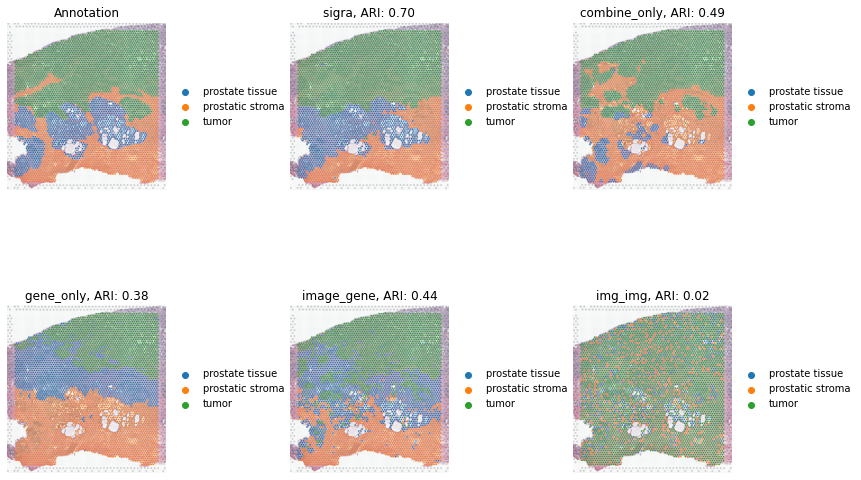

In [14]:
draw_spatial_ablation(sigra, save_path=f'pdfs/{slice_id}_ablation.pdf')

## save csv from sigra

In [15]:
def adata2csv(adata, save_path):
    df = pd.DataFrame(index=adata.obs.index)
    df['sigra_matched'] = adata.obs['sigra_matched']
    df['scanpy_matched'] = adata.obs['scanpy_matched']
    df['spagcn_matched'] = adata.obs['spagcn_matched']
    df['stlearn_matched'] = adata.obs['stlearn_matched']
    df['seurat_matched'] = adata.obs['seurat_matched']
    df['bayesspace_matched'] = adata.obs['bayesspace_matched']
    df['combine_only_matched'] = adata.obs['combine_only_matched']
    df['gene_only_matched'] = adata.obs['gene_only_matched']
    df['img_gene_matched'] = adata.obs['img_gene_matched']
    df['img_img_matched'] = adata.obs['img_img_matched']
    df.to_csv(save_path)
    return df

In [16]:
df = adata2csv(sigra, f'pdfs/{slice_id}metadata.csv')

## overall commands for another tissue slice

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


res: 1.50, count: 24, ncluster: 4
res: 0.75, count: 16, ncluster: 4
res: 0.38, count: 9, ncluster: 4
res: 0.19, count: 6, ncluster: 4
res: 0.09, count: 4, ncluster: 4
find 0.09375


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[(0, 0), (1, 3), (2, 2), (3, 1)]
[(0, 0), (1, 3), (2, 2), (3, 1)]
[(0, 0), (1, 1), (2, 2)]
[(0, 3), (1, 2), (2, 0), (3, 1)]
[(0, 0), (1, 3), (2, 2), (3, 1)]
[(0, 1), (1, 0), (2, 2), (3, 3)]
res: 1.50, count: 23, ncluster: 4
res: 0.75, count: 15, ncluster: 4
res: 0.38, count: 9, ncluster: 4
res: 0.19, count: 5, ncluster: 4
res: 0.09, count: 2, ncluster: 4
res: 0.14, count: 3, ncluster: 4
res: 0.16, count: 4, ncluster: 4
find 0.1640625
res: 1.50, count: 18, ncluster: 4
res: 0.75, count: 9, ncluster: 4
res: 0.38, count: 4, ncluster: 4
find 0.375
res: 1.50, count: 18, ncluster: 4
res: 0.75, count: 9, ncluster: 4
res: 0.38, count: 4, ncluster: 4
find 0.375
res: 1.50, count: 26, ncluster: 4
res: 0.75, count: 15, ncluster: 4
res: 0.38, count: 9, ncluster: 4
res: 0.19, count: 5, ncluster: 4
res: 0.09, count: 3, ncluster: 4
res: 0.14, count: 4, ncluster: 4
find 0.140625


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[(0, 1), (1, 0), (2, 2), (3, 3)]
[(0, 0), (1, 3), (2, 2), (3, 1)]
[(0, 0), (1, 3), (2, 2), (3, 1)]
[(0, 0), (1, 1), (2, 3), (3, 2)]


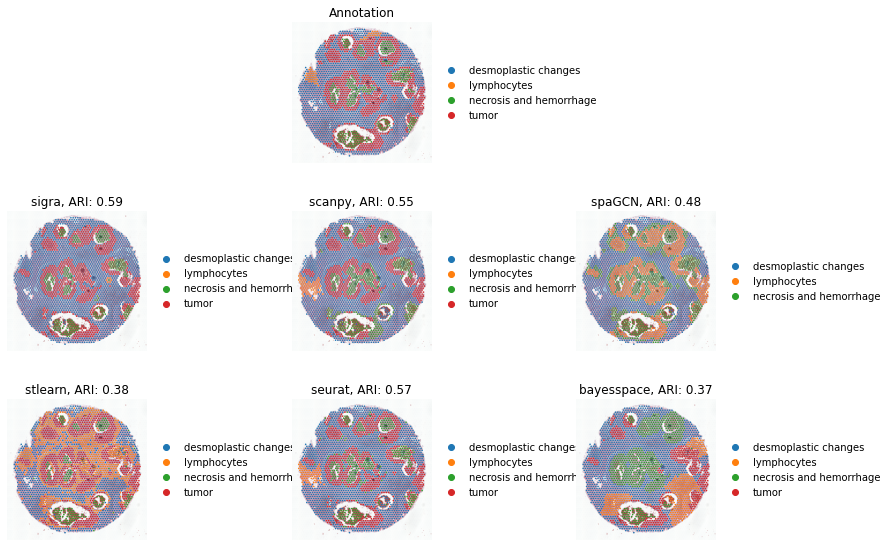

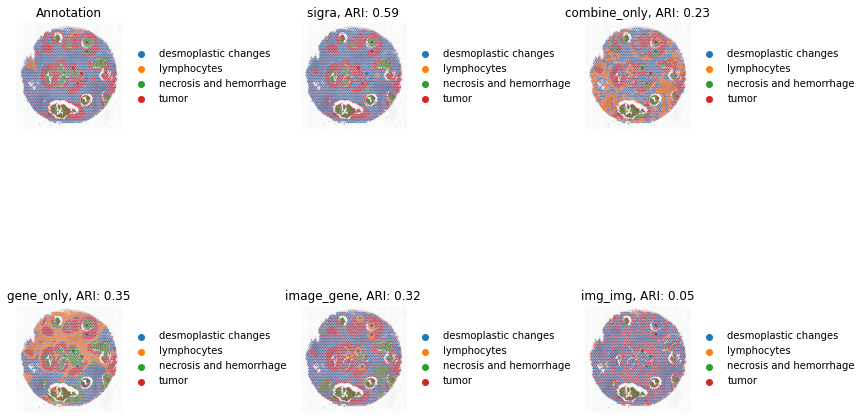

In [17]:
# define tissue slice
root = 'adatas'
slice_id = '10x_BreastCancer_'
num_cluster = 4

# load data
raw_adata = sc.read(os.path.join(root, f'{slice_id}raw.h5ad'))
sigra_root = os.path.join(root, f'{slice_id}sigra_final.h5ad')
scanpy_root = os.path.join(root, f'{slice_id}scanpy.h5ad')
spagcn_root = os.path.join(root, f'{slice_id}spaGCN.h5ad')
stlearn_root = os.path.join(root, f'{slice_id}stlearn.csv')
seurat_root = os.path.join(root, f'{slice_id}Seurat.csv')
bspace_root = os.path.join(root, f'{slice_id}bayesSpace.csv')
# load annotation
sigra = load_data(sigra_root, scanpy_root, spagcn_root, stlearn_root, seurat_root, bspace_root, num_cluster=num_cluster)
sigra.obs['annotation'] = raw_adata.obs['annotation']
# match cluster
sigra = match_anno(sigra.obs['annotation'], sigra, name='sigra')
sigra = match_anno(sigra.obs['annotation'], sigra, name='scanpy')
sigra = match_anno(sigra.obs['annotation'], sigra, name='spagcn')
sigra = match_anno(sigra.obs['annotation'], sigra, name='stlearn')
sigra = match_anno(sigra.obs['annotation'], sigra, name='seurat')
sigra = match_anno(sigra.obs['annotation'], sigra, name='bayesspace')
# draw spatial
draw_spatial_benchmarks(sigra, save_path=f'pdfs/{slice_id}_benchmark.pdf')

# draw ablation
gene_only = get_leiden_from_ablation(f'{root}/{slice_id}gene.h5ad', num_cluster)
img_gene = get_leiden_from_ablation(f'{root}/{slice_id}img_gene.h5ad', num_cluster)
img_img = get_leiden_from_ablation(f'{root}/{slice_id}img_img.h5ad',num_cluster)
combine_only = get_leiden_from_ablation(f'{root}/{slice_id}combine_only.h5ad', num_cluster)

sigra.obs['gene_only'] = gene_only
sigra.obs['img_gene'] = img_gene
sigra.obs['img_img'] = img_img
sigra.obs['combine_only'] = combine_only
sigra = match_anno(sigra.obs['annotation'], sigra, name='gene_only')
sigra = match_anno(sigra.obs['annotation'], sigra, name='img_gene')
sigra = match_anno(sigra.obs['annotation'], sigra, name='img_img')
sigra = match_anno(sigra.obs['annotation'], sigra, name='combine_only')


